In [1]:
import torch
from torch.utils.data import DataLoader, TensorDataset
import numpy as np
import struct
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix
import seaborn as sns

import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
import matplotlib.pyplot as plt

# 相關的模型設定

batchsize = 512
num_epochs = 20
learning_rate = 0.001
output_class = 26

In [2]:
# 讀取 MNIST idx 格式檔案的函數
def read_idx_images(filename):
    with open(filename, 'rb') as f:
        magic, num, rows, cols = struct.unpack('>IIII', f.read(16))
        images = np.frombuffer(f.read(), dtype=np.uint8).reshape(num, rows, cols)
    return images

def read_idx_labels(filename):
    with open(filename, 'rb') as f:
        magic, num = struct.unpack('>II', f.read(8))
        labels = np.frombuffer(f.read(), dtype=np.uint8)
    return labels

# 載入訓練和測試資料
train_images = read_idx_images('D:\\Topic\\USTC-TK2016\\5_Mnist\\All\\train-images-idx3-ubyte')
train_labels = read_idx_labels('D:\\Topic\\USTC-TK2016\\5_Mnist\\All\\train-labels-idx1-ubyte')
test_images = read_idx_images('D:\\Topic\\USTC-TK2016\\5_Mnist\\All\\test-images-idx3-ubyte')
test_labels = read_idx_labels('D:\\Topic\\USTC-TK2016\\5_Mnist\\All\\test-labels-idx1-ubyte')

# 資料預處理
train_images = train_images.astype(np.float32) / 255.0
test_images = test_images.astype(np.float32) / 255.0

# 轉換為 PyTorch tensors
train_images = torch.FloatTensor(train_images).unsqueeze(1)  # 添加通道維度
test_images = torch.FloatTensor(test_images).unsqueeze(1)
train_labels = torch.LongTensor(train_labels)
test_labels = torch.LongTensor(test_labels)

# 建立 DataLoader
train_dataset = TensorDataset(train_images, train_labels)
test_dataset = TensorDataset(test_images, test_labels)
train_loader = DataLoader(train_dataset, batch_size = batchsize, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size = batchsize, shuffle=False)



C:\Users\JinTing\AppData\Local\Temp\ipykernel_16464\2925951490.py:27: UserWarning: The given NumPy array is not writable, and PyTorch does not support non-writable tensors. This means writing to this tensor will result in undefined behavior. You may want to copy the array to protect its data or make it writable before converting it to a tensor. This type of warning will be suppressed for the rest of this program. (Triggered internally at C:\actions-runner\_work\pytorch\pytorch\pytorch\torch\csrc\utils\tensor_numpy.cpp:209.)
  train_labels = torch.LongTensor(train_labels)


In [3]:
# 定義基本 CNN 模型
class LeNet(nn.Module):
    def __init__(self, num_classes = output_class):
        super(LeNet, self).__init__()
        # LeNet-5 architecture for MNIST
        self.features = nn.Sequential(
            # C1: 卷積層 - 1@28x28 -> 6@24x24
            nn.Conv2d(1, 6, kernel_size=5),
            nn.Tanh(),
            # S2: 池化層 - 6@24x24 -> 6@12x12
            nn.AvgPool2d(kernel_size=2, stride=2),
            # C3: 卷積層 - 6@12x12 -> 16@8x8
            nn.Conv2d(6, 16, kernel_size=5),
            nn.Tanh(),
            # S4: 池化層 - 16@8x8 -> 16@4x4
            nn.AvgPool2d(kernel_size=2, stride=2),
        )
        
        self.classifier = nn.Sequential(
            # C5: 全連接層 - 16*4*4 -> 120
            nn.Linear(16 * 4 * 4, 120),
            nn.Tanh(),
            # F6: 全連接層 - 120 -> 84
            nn.Linear(120, 84),
            nn.Tanh(),
            # 輸出層 - 84 -> num_classes
            nn.Linear(84, num_classes),
        )
        
    def forward(self, x):
        x = self.features(x)
        x = x.view(x.size(0), -1)
        x = self.classifier(x)
        return x

# 初始化模型、損失函數和優化器
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = LeNet().to(device)
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr = learning_rate)

# 訓練模型
train_losses = []
train_accuracies = []

print("開始訓練...")
for epoch in range(num_epochs):
    model.train()
    running_loss = 0.0
    correct = 0
    total = 0
    
    for batch_idx, (data, target) in enumerate(train_loader):
        data, target = data.to(device), target.to(device)
        
        optimizer.zero_grad()
        output = model(data)
        loss = criterion(output, target)
        loss.backward()
        optimizer.step()
        
        running_loss += loss.item()
        _, predicted = torch.max(output.data, 1)
        total += target.size(0)
        correct += (predicted == target).sum().item()
    
    epoch_loss = running_loss / len(train_loader)
    epoch_acc = 100 * correct / total
    train_losses.append(epoch_loss)
    train_accuracies.append(epoch_acc)
    
    print(f'Epoch [{epoch+1}/{num_epochs}], Loss: {epoch_loss:.4f}, Accuracy: {epoch_acc:.2f}%')

開始訓練...
Epoch [1/20], Loss: 1.6331, Accuracy: 41.59%
Epoch [2/20], Loss: 0.8335, Accuracy: 68.57%
Epoch [3/20], Loss: 0.3490, Accuracy: 87.45%
Epoch [4/20], Loss: 0.1932, Accuracy: 92.35%
Epoch [5/20], Loss: 0.1456, Accuracy: 93.85%
Epoch [6/20], Loss: 0.1150, Accuracy: 95.25%
Epoch [7/20], Loss: 0.0876, Accuracy: 96.63%
Epoch [8/20], Loss: 0.0730, Accuracy: 97.47%
Epoch [9/20], Loss: 0.0502, Accuracy: 98.28%
Epoch [10/20], Loss: 0.0411, Accuracy: 98.60%
Epoch [11/20], Loss: 0.0353, Accuracy: 98.80%
Epoch [12/20], Loss: 0.0295, Accuracy: 99.00%
Epoch [13/20], Loss: 0.0256, Accuracy: 99.13%
Epoch [14/20], Loss: 0.0223, Accuracy: 99.24%
Epoch [15/20], Loss: 0.0210, Accuracy: 99.27%
Epoch [16/20], Loss: 0.0186, Accuracy: 99.35%
Epoch [17/20], Loss: 0.0167, Accuracy: 99.41%
Epoch [18/20], Loss: 0.0155, Accuracy: 99.45%
Epoch [19/20], Loss: 0.0143, Accuracy: 99.49%
Epoch [20/20], Loss: 0.0132, Accuracy: 99.52%



=== 模型評估結果 ===
測試準確率: 99.50%
測試損失: 0.0152
精確率 (Precision): 0.9950
召回率 (Recall): 0.9950
F1-Score: 0.9950


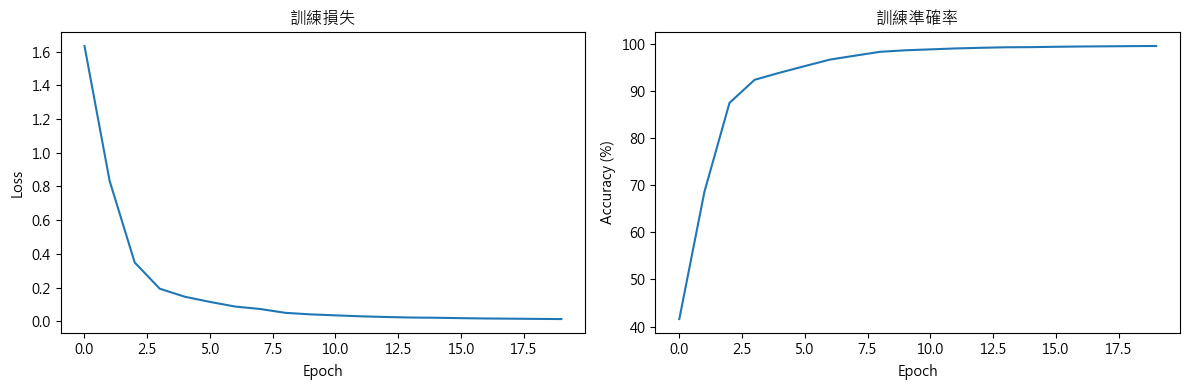

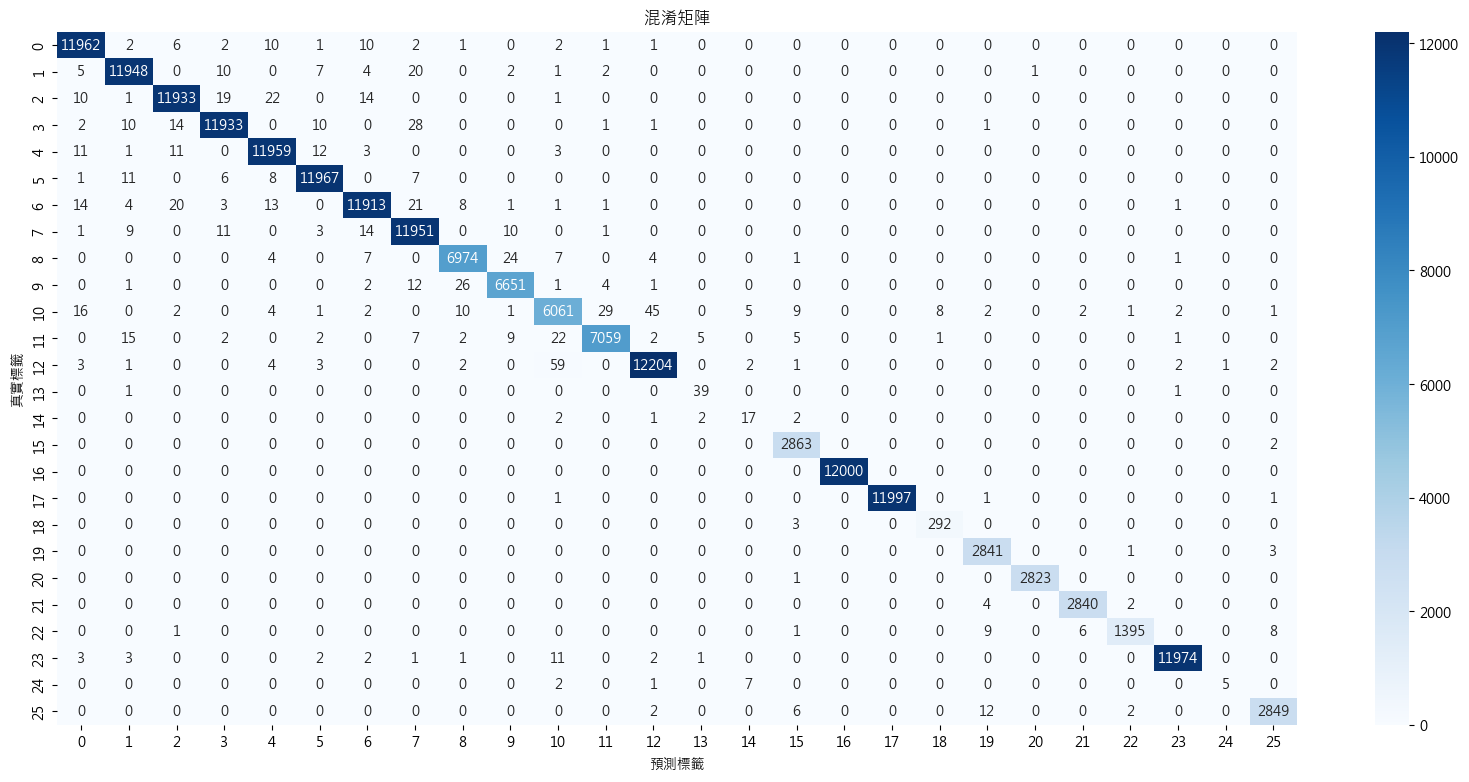

In [4]:
# 評估模型
model.eval()
y_true = []
y_pred = []
test_loss = 0
correct = 0
total = 0

plt.rc('font', family='Microsoft JhengHei')

with torch.no_grad():
    for data, target in test_loader:
        data, target = data.to(device), target.to(device)
        output = model(data)
        test_loss += criterion(output, target).item()
        _, predicted = torch.max(output.data, 1)
        total += target.size(0)
        correct += (predicted == target).sum().item()
        
        y_true.extend(target.cpu().numpy())
        y_pred.extend(predicted.cpu().numpy())

# 計算各項指標
test_accuracy = 100 * correct / total
test_loss = test_loss / len(test_loader)
precision = precision_score(y_true, y_pred, average='weighted')
recall = recall_score(y_true, y_pred, average='weighted')
f1 = f1_score(y_true, y_pred, average='weighted')

# 顯示結果
print("\n=== 模型評估結果 ===")
print(f"測試準確率: {test_accuracy:.2f}%")
print(f"測試損失: {test_loss:.4f}")
print(f"精確率 (Precision): {precision:.4f}")
print(f"召回率 (Recall): {recall:.4f}")
print(f"F1-Score: {f1:.4f}")

# 繪製訓練過程
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 4))

ax1.plot(train_losses)
ax1.set_title('訓練損失')
ax1.set_xlabel('Epoch')
ax1.set_ylabel('Loss')

ax2.plot(train_accuracies)
ax2.set_title('訓練準確率')
ax2.set_xlabel('Epoch')
ax2.set_ylabel('Accuracy (%)')

plt.tight_layout()
plt.show()

# 繪製混淆矩陣
cm = confusion_matrix(y_true, y_pred)
plt.figure(figsize=(20, 9))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.title('混淆矩陣')
plt.xlabel('預測標籤')
plt.ylabel('真實標籤')
plt.show()

In [5]:
# 儲存模型
torch.save(model.state_dict(), 'LeNet_mnist_model.pth')
print("模型已儲存為 'LeNet_mnist_model.pth'")

# 如果需要儲存完整模型（包含架構）
torch.save(model, 'LeNet_mnist_complete_model.pth')
print("完整模型已儲存為 'LeNet_mnist_complete_model.pth'")

模型已儲存為 'LeNet_mnist_model.pth'
完整模型已儲存為 'LeNet_mnist_complete_model.pth'
